In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from root_dataset import Train_dataset, Test_dataset
import albumentations as albu
import pytorch_ssim
import pytorch_iou
import model
import random
import numpy as np
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
height = 512

In [4]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        #albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        # albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [6]:
train_aug = get_train_augmentation(height)
val_aug = get_val_augmentation(height)

In [7]:
train = Train_dataset(height,train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Train_dataset(height,val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0196.png', 'AAE_0182.png', 'AAE_0021.png', 'AAE_0236.png', 'AAE_0140.png', 'AAE_0154.png', 'AAE_0181.png', 'AAE_0156.png', 'AAE_0036.png', 'AAE_0022.png', 'AAE_0209.png', 'AAE_0180.png', 'AAE_0184.png', 'AAE_0190.png', 'AAE_0147.png', 'AAE_0027.png', 'AAE_0218.png', 'AAE_0146.png', 'AAE_0185.png', 'AAE_0193.png', 'AAE_0150.png', 'AAE_0226.png', 'AAE_0233.png', 'AAE_0019.png', 'AAE_0025.png', 'AAE_0179.png', 'AAE_0145.png', 'AAE_0192.png', 'AAE_0136.png', 'AAE_0057.png', 'AAE_0080.png', 'AAE_0041.png', 'AAE_0040.png', 'AAE_0068.png', 'AAE_0083.png', 'AAE_0097.png', 'AAE_0124.png', 'AAE_0087.png', 'AAE_0045.png', 'AAE_0119.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0047.png', 'AAE_0085.png', 'AAE_0117.png', 'AAE_0063.png', 'AAE_0076.png', 'AAE_0062.png', 'AAE_0089.png', 'AAE_0116.png', 'AAE_0100.png', 'AAE_0114.png', 'AAE_0048.png', 'AAE_0101.png', 'AAE_0071.png', 'AAE_0058.png', 'AAE_0070.png', 'AAE_0073.png', 'AAE_0098.png', 'AAE_0107.png', 'AAE_0174.png', 'AAE_0028.png', 'AAE_00

<Figure size 640x480 with 0 Axes>

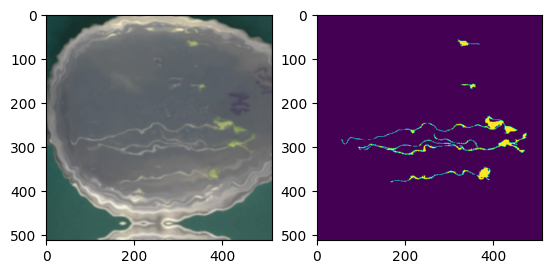

In [8]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0).cpu())
axarr[1].imshow(mask.permute(1,2,0).cpu())

In [9]:
model = model.UNet(3,1)

In [10]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False)

In [11]:
bce_loss = torch.nn.BCELoss(size_average=True)
ssim_loss = pytorch_ssim.SSIM(window_size=11,size_average=True)
iou_loss = pytorch_iou.IOU(size_average=True)
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5,verbose=True)

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [12]:
def bce_ssim_loss(pred,target):

	bce_out = bce_loss(pred,target)
	ssim_out = 1 - ssim_loss(pred,target)
	iou_out = iou_loss(pred,target)

	loss = bce_out + ssim_out + iou_out

	return loss

In [13]:
epochs = 200
patience = 20
model_path = 'models/new_loss_model.pt'

In [14]:
model.to(device)
best_loss = 100
counter = 0
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_ssim_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = bce_ssim_loss(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    improve = False

    if val_loss < best_loss: 
        best_loss = val_loss
        improve = True
        print('model saved')
        torch.save(model,model_path)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if not improve:
        counter += 1
        if counter > patience:
            print('early stop')
            break
    else:
        counter = 0
        

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


model saved
Epoch [1/200] | Train Loss: 2.6283 | Val Loss: 2.6407


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [2/200] | Train Loss: 2.4515 | Val Loss: 2.5193


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [3/200] | Train Loss: 2.3667 | Val Loss: 2.4292


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [4/200] | Train Loss: 2.3082 | Val Loss: 2.3709


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [5/200] | Train Loss: 2.2688 | Val Loss: 2.3100


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [6/200] | Train Loss: 2.2395 | Val Loss: 2.2654


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [7/200] | Train Loss: 2.2008 | Val Loss: 2.2161


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


model saved
Epoch [8/200] | Train Loss: 2.1743 | Val Loss: 2.1606


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [9/200] | Train Loss: 2.1595 | Val Loss: 2.1484


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [10/200] | Train Loss: 2.1404 | Val Loss: 2.1310


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [11/200] | Train Loss: 2.1300 | Val Loss: 2.1034


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Epoch [12/200] | Train Loss: 2.1108 | Val Loss: 2.1078


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [13/200] | Train Loss: 2.0991 | Val Loss: 2.0858


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


model saved
Epoch [14/200] | Train Loss: 2.0856 | Val Loss: 1.9791


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


Epoch [15/200] | Train Loss: 2.0616 | Val Loss: 2.0417


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Epoch [16/200] | Train Loss: 2.0280 | Val Loss: 1.9792


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Epoch [17/200] | Train Loss: 1.9923 | Val Loss: 2.0661


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [18/200] | Train Loss: 1.9344 | Val Loss: 1.8201


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Epoch [19/200] | Train Loss: 1.8830 | Val Loss: 1.9233


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Epoch [20/200] | Train Loss: 1.8125 | Val Loss: 2.0293


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


model saved
Epoch [21/200] | Train Loss: 1.7137 | Val Loss: 1.6210


100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Epoch [22/200] | Train Loss: 1.6281 | Val Loss: 1.6364


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Epoch [23/200] | Train Loss: 1.5530 | Val Loss: 1.6412


 38%|███▊      | 3/8 [00:17<00:29,  5.99s/it]


KeyboardInterrupt: 

Epoch [61/100] | Train Loss: 0.8235 | Val Loss: 0.8208

In [15]:
model = torch.load(model_path)

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [16]:
test = Test_dataset(val_aug,'crosval/test',device)

['AAE_0223.png', 'AAE_0237.png', 'AAE_0221.png', 'AAE_0023.png', 'AAE_0086.png', 'gifs-col-0-3.jpg', 'AAE_0074.png', 'AAE_0138.png', 'AAE_0160.png', 'AAE_0172.png', 'AAE_0205.png']


In [17]:
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [18]:
for inputs in tqdm(test_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


In [19]:
outputs.shape

torch.Size([1, 1, 512, 512])

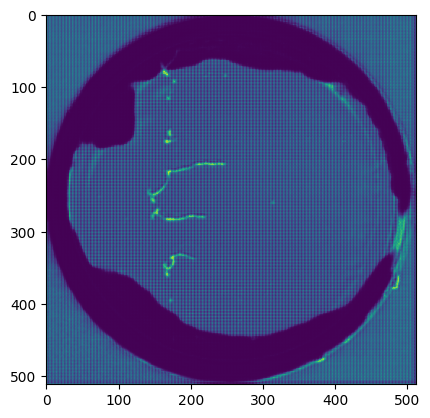

In [20]:
for i in outputs:
    i.reshape(1, height, height)
    plt.imshow(i.cpu().permute(1,2,0).detach().numpy())
    plt.pause(1)